In [1]:
import argparse
import random
import numpy as np
import sys, os
import logging
import galsim
import galsim.roman as roman
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import make_lupton_rgb

In [2]:
logging.basicConfig(format="%(message)s", stream=sys.stdout)
logger = logging.getLogger("demo13")
logging_levels = { 0: logging.CRITICAL,
                   1: logging.WARNING,
                   2: logging.INFO,
                   3: logging.DEBUG }

In [3]:
# cat1 = galsim.COSMOSCatalog(sample='25.2', area=roman.collecting_area, exptime=roman.exptime)
# cat2 = galsim.COSMOSCatalog(sample='23.5', area=roman.collecting_area, exptime=roman.exptime)

# cat1 = galsim.COSMOSCatalog(sample='25.2', area=9900, exptime=565)
cat = galsim.COSMOSCatalog(sample='23.5', area=roman.collecting_area, exptime=roman.exptime)

In [4]:
#Euclid's filter

datapath = galsim.meta_data.share_dir
filter_filename = os.path.join(datapath, 'bandpasses/euclid.dat')
bandpass = galsim.Bandpass(filter_filename, wave_type='Angstrom')

# PSF

In [5]:
use_SCA = 7

In [6]:
import numpy as np
import os
from galsim.utilities import LRU_Cache

"""
@file roman_psfs.py

Part of the Roman Space Telescope module.  This file includes routines needed to define a realistic
PSF for Roman.
"""

# Define a default set of bandpasses for which this routine works.
default_bandpass_list = ['J129', 'F184', 'W149', 'Y106', 'Z087', 'H158']
# Prefix for files containing information about Zernikes for each SCA for cycle 7.
zemax_filepref = "Roman_Phase-A_SRR_WFC_Zernike_and_Field_Data_170727"
zemax_filesuff = '.txt'
zemax_wavelength = 1293. #nm

# These need 'SCA*' prepended to the start to get the file name, and they live in
# the share/roman directory.
pupil_plane_file_longwave = '_full_mask.fits.gz'
pupil_plane_file_shortwave = '_rim_mask.fits.gz'

def __make_aperture(SCA, pupil_plane_type, pupil_bin, wave, gsparams):
    from galsim.roman import diameter, obscuration
    from galsim import fits
    from galsim import meta_data
    from galsim.phase_psf import Aperture

    # Load the pupil plane image.
    if pupil_plane_type == 'long':
        pupil_plane_im = os.path.join(meta_data.share_dir, 'roman',
            'SCA%d'%SCA + pupil_plane_file_longwave)
    else:
        pupil_plane_im = os.path.join(meta_data.share_dir, 'roman',
            'SCA%d'%SCA + pupil_plane_file_shortwave)
    pupil_plane_im = fits.read(pupil_plane_im, read_header=True)
    # Native pixel scale in the file is for the exit pupil.  We want the scale of the
    # entrance pupil.  Fortunately, they provide the conversion as PUPILMAG in the header.
    # They also use microns for units, and we want meters, hence the extra 1.e-6.
    pupil_plane_im.scale *= pupil_plane_im.header['PUPILMAG'] * 1.e-6

    pupil_plane_im = pupil_plane_im.bin(pupil_bin,pupil_bin)
    
    # diameter = 1.3
    aper = Aperture(lam=wave, diam=diameter,
                    obscuration=obscuration,
                    pupil_plane_im=pupil_plane_im,
                    gsparams=gsparams)
    return aper

# Usually a given run will only need one or a few different apertures for repeated getPSF calls.
# So cache those apertures here to avoid having to remake them.
_make_aperture = LRU_Cache(__make_aperture)

def _get_single_PSF(SCA, bandpass, SCA_pos, pupil_bin,
                    n_waves, extra_aberrations, wavelength,
                    pupil_plane_type, gsparams):
    """Routine for making a single PSF.  This gets called by `getPSF` after it parses all the
       options that were passed in.  Users will not directly interact with this routine.
    """
    from galsim import OpticalPSF, ChromaticOpticalPSF
    from galsim.roman import diameter
    from galsim.bandpass import Bandpass

    if wavelength is None:
        wave = zemax_wavelength
    elif isinstance(wavelength, Bandpass):
        wave = wavelength = wavelength.effective_wavelength
    else:
        wave = wavelength

    # All parameters relevant to the aperture.  We may be able to use a cached version.
    aper = _make_aperture(SCA, pupil_plane_type, pupil_bin, wave, gsparams)

    # Start reading in the aberrations for that SCA
    aberrations, x_pos, y_pos = _read_aberrations(SCA)
    # Do bilinear interpolation, unless we're exactly at the center (default).
    use_aberrations = _interp_aberrations_bilinear(aberrations, x_pos, y_pos, SCA_pos)

    if extra_aberrations is not None:
        use_aberrations[:len(extra_aberrations)] += extra_aberrations
    # We don't want to use piston, tip, or tilt aberrations.  The former doesn't affect the
    # appearance of the PSF, and the latter cause centroid shifts.  So, we set the first 4
    # numbers (corresponding to a place-holder, piston, tip, and tilt) to zero.
    use_aberrations[0:4] = 0.
    
    # Now set up the PSF, including the option to interpolate over waves
    
    # diameter = 1.3
    if wavelength is None:
        PSF = ChromaticOpticalPSF(lam=zemax_wavelength,
                                  diam=diameter, aberrations=use_aberrations,
                                  aper=aper, gsparams=gsparams)
        if n_waves is not None:
            # To decide the range of wavelengths to use, check the bandpass.
            bp = bandpass
            PSF = PSF.interpolate(waves=np.linspace(bp.blue_limit, bp.red_limit, n_waves),
                                  oversample_fac=1.5)
    else:
        tmp_aberrations = use_aberrations * zemax_wavelength / wavelength
        PSF = OpticalPSF(lam=wavelength, diam=diameter,
                         aberrations=tmp_aberrations,
                         aper=aper, gsparams=gsparams)

    return PSF
def _read_aberrations(SCA):
    """
    This is a helper routine that reads in aberrations for a particular SCA and wavelength (given as
    galsim.roman.roman_psfs.zemax_wavelength) from stored files, and returns them along with the
    field positions.

    Parameters:
        SCA:        The identifier for the SCA, from 1-18.

    Returns:
        NumPy arrays containing the aberrations, and x and y field positions.
    """
    from galsim import meta_data
    from galsim.roman import pixel_scale, n_pix, pixel_scale_mm

    # Construct filename.
    sca_str = '_%02d'%SCA
    infile = os.path.join(meta_data.share_dir, 'roman',
                          zemax_filepref + sca_str + zemax_filesuff)

    # Read in data.
    dat = np.loadtxt(infile)
    # It actually has 5 field positions, not just 1, to allow us to make position-dependent PSFs
    # within an SCA eventually.  Put it in the required format: an array of length (5 field
    # positions, 23 Zernikes), with the first entry empty (Zernike polynomials are 1-indexed so we
    # use entries 1-22).  The units are waves.
    aberrations = np.zeros((5,23))
    aberrations[:,1:] = dat[:,5:]
    # Also get the field position.  The file gives it in mm with respect to the center, but we
    # want it in pixels with respect to the corner. The pixel size of the detector is 0.01 mm/pixel
    # The y-coordinates have the opposite signs to the corresponding WFI location, explained 
    # in the Roman file.

    x_sca_pos = dat[:,1]/pixel_scale_mm + n_pix/2
    y_sca_pos = n_pix/2 - dat[:,2]/pixel_scale_mm
    return aberrations, x_sca_pos, y_sca_pos
def _interp_aberrations_bilinear(aberrations, x_pos, y_pos, SCA_pos):
    """
    This is a helper routine to do bilinear interpolation of aberrations defined at 4 field
    positions: the four corners.  Note that we also have aberrations at the center position,
    but these are generally quite close (within a few percent) of what would come from this bilinear
    interpolation.  So for simplicity, we just do the bilinear interpolation.
    """
    min_x = np.min(x_pos)
    min_y = np.min(y_pos)
    max_x = np.max(x_pos)
    max_y = np.max(y_pos)
    x_frac = (SCA_pos.x - min_x) / (max_x - min_x)
    y_frac = (SCA_pos.y - min_y) / (max_y - min_y)
    lower_x_lower_y_ab = aberrations[(x_pos==min_x) & (y_pos==min_y), :]
    lower_x_upper_y_ab = aberrations[(x_pos==min_x) & (y_pos==max_y), :]
    upper_x_lower_y_ab = aberrations[(x_pos==max_x) & (y_pos==min_y), :]
    upper_x_upper_y_ab = aberrations[(x_pos==max_x) & (y_pos==max_y), :]
    interp_ab = (1.0-x_frac)*(1.0-y_frac)*lower_x_lower_y_ab + \
        (1.0-x_frac)*y_frac*lower_x_upper_y_ab + \
        x_frac*(1.0-y_frac)*upper_x_lower_y_ab + \
        x_frac*y_frac*upper_x_upper_y_ab

    return interp_ab.flatten()

In [7]:
# n_pix = galsim.roman.n_pix
# # n_pix = 64
# psf = _get_single_PSF(SCA = use_SCA, bandpass = bandpass,SCA_pos=galsim.PositionD(n_pix/2,n_pix/2),
#                       pupil_bin=16, n_waves=10, extra_aberrations=None,
#                        wavelength=None, gsparams=None, pupil_plane_type = 'short')

In [ ]:
i=200
psf_sed = galsim.SED('1', wave_type='Angstrom', flux_type='flambda')
psf_star = galsim.DeltaFunction()

# Faint galaxy
logger.debug('Faint galaxy')

# Select a random galaxy from the catalog.
obj = cat.makeGalaxy(chromatic=True, gal_type='parametric', index=i)
logger.debug('galaxy index = %s',obj.index)
# obj = obj.shear(e1 = 0.01,e2=0.01)


# Convolve the (chromatic) object with the (chromatic) PSF.
pixel_scale = roman.pixel_scale
wcs = galsim.PixelScale(pixel_scale) 
im_obj = obj.drawImage(bandpass,nx=64,ny=64,wcs=wcs)
final = galsim.Convolve(obj, psf)
stamp = final.drawImage(bandpass, nx=64,ny=64, wcs = wcs)
psf_img = galsim.Convolve([psf_star, psf]) * psf_sed.withFlux(1, bandpass)
im_psf = psf_img.drawImage(bandpass,nx=64,ny=64,wcs=wcs)

In [ ]:
fig, axs = plt.subplots(1,2,figsize=[15,10])

im = axs[0].imshow(im_obj.array,cmap='gist_stern',origin='lower')
axs[0].set_title('galaxy')
fig.colorbar(im,ax=axs[0],shrink=0.5)
s = galsim.hsm.FindAdaptiveMom(im_obj, round_moments = False )
print("- AdaptiveMom shapes:")
print("Mom:", s.observed_shape.e1, s.observed_shape.e2, s.moments_sigma, s.error_message.strip("\n"))
print()

im = axs[1].imshow(stamp.array,cmap='gist_stern',origin='lower')
axs[1].set_title('convolved galaxy')
s = galsim.hsm.EstimateShear(stamp, im_psf)
print("- EstimateShear shapes:")
print("Uncorr:", s.observed_shape.e1, s.observed_shape.e2, s.error_message.strip("\n"))
print("Corr:", s.corrected_e1, s.corrected_e2, s.moments_sigma)
print("PSF shape:", s.psf_shape.e1,s.psf_shape.e2, s.psf_sigma)
fig.colorbar(im,ax=axs[1],shrink=0.5)

# plt.savefig('image/2.png')


In [ ]:
im = plt.imshow(im_psf.array,cmap='gist_stern',origin='lower')
plt.title('psf')
plt.colorbar()
# plt.savefig('image/psf.png')

# Draw image

In [11]:
def draw_image(obj, psf, scale, nx = 64, ny = 64, chromatic = False, bandpass = None):
    if chromatic == False:
        im_obj = obj.drawImage(nx=nx,ny=ny,scale = scale)
        final = galsim.Convolve(obj, psf)
        stamp = final.drawImage(nx=nx,ny=ny, scale = scale)
    else:
        if bandpass == None:
            raise DrawError("No bandpass")
        else:
            im_obj = obj.drawImage(bandpass,nx=64,ny=64, scale = pixel_scale)
            final = galsim.Convolve(obj, psf)
            stamp = final.drawImage(bandpass, nx=64,ny=64, scale = pixel_scale)

    return stamp

# Function to create catalog

In [12]:
pixel_scale = roman.pixel_scale

def create_catalog(nobj, shear = False, bandpass = False,catalog = None, chromatic = False):
    if bandpass == False:
        datapath = galsim.meta_data.share_dir
        filter_filename = os.path.join(datapath, 'bandpasses/euclid.dat')
        bandpass = galsim.Bandpass(filter_filename, wave_type='Angstrom')
    i=0

    samples1=[]             # First sample
    samples2=[]             # 
    
    in_shape1=[]            #storing shape of all galaxies in both two samples to check whether the avg shape = 0
    in_shape2=[]

    if chromatic == False:
        psf = galsim.Gaussian(flux=1., sigma=0.7285587787628174)
        im_psf = psf.drawImage(nx=32,ny=32,scale = pixel_scale)
    else:
        n_pix = galsim.roman.n_pix
        # n_pix = 64
        psf = _get_single_PSF(SCA = use_SCA, bandpass = bandpass,SCA_pos=galsim.PositionD(n_pix/2,n_pix/2),
                      pupil_bin=16, n_waves=10, extra_aberrations=None,
                       wavelength=None, gsparams=None, pupil_plane_type = 'short')
        psf_sed = galsim.SED('1', wave_type='Angstrom', flux_type='flambda')
        psf_star = galsim.DeltaFunction()
        psf_img = galsim.Convolve([psf_star, psf]) * psf_sed.withFlux(1, bandpass)
        im_psf = psf_img.drawImage(bandpass,nx=32,ny=32, scale=pixel_scale)
    
    while i < nobj:
        rand = random.random()
        rand1 = -random.random()
        angle = rand*2*np.pi*galsim.radians

        if catalog == None:
            obj = galsim.Gaussian(flux = 1e5, sigma = rand)
            if shear == True:
                if np.sqrt(rand**2+rand1**2) >= 1:
                    obj = obj.shear(g1 = rand)
                else:
                    obj = obj.shear(g1 = rand, g2 = rand1)
        else:
            a = random.randint(0, catalog.nobjects-1)
            obj = catalog.makeGalaxy(chromatic=True, gal_type='parametric', index=a)
        
        obj = obj.rotate(angle)
        
        obj1 = obj.rotate(90*galsim.degrees)
        
        try:
            if chromatic == False:
                stamp = draw_image(obj, psf, pixel_scale)
                stamp1 = draw_image(obj1, psf, pixel_scale)
            else:
                stamp = draw_image(obj, psf, chromatic = True, bandpass = bandpass)
                stamp1 = draw_image(obj1, psf, chromatic = True, bandpass = bandpass)

            
            s = galsim.hsm.EstimateShear(stamp, im_psf)
            o = galsim.hsm.FindAdaptiveMom(im_obj, round_moments = False )
            
            s1 = galsim.hsm.EstimateShear(stamp1, im_psf)
            o1 = galsim.hsm.FindAdaptiveMom(im_obj1, round_moments = False )
            
            samples1.append(obj)
            samples2.append(obj1)
            i+=1
            in_shape1.append([o.observed_shape.e1, o1.observed_shape.e1])
            in_shape2.append([o.observed_shape.e2, o1.observed_shape.e2])
        except galsim.GalSimFFTSizeError:
            pass
        except galsim.GalSimHSMError:
            pass
        
    samples1 = np.asarray(samples1)
    samples2 = np.asarray(samples2)
    in_shape1 = np.asarray(in_shape1)
    in_shape2 = np.asarray(in_shape2)

    avg = in_shape1.mean()
    return samples1, samples2, avg 

In [9]:
samples1, samples2, avg = create_catalog(10000, shear = True, bandpass = False,catalog = None, chromatic = False)

In [10]:
avg

-1.3832868720406455e-10

# Simulation

## Gaussian PSF + Gaussian galaxy

In [13]:
psf = galsim.Gaussian(flux=1., sigma=0.7285587787628174)
im_psf = psf.drawImage(nx=32,ny=32,scale = pixel_scale)

In [11]:
nobj = 10000
i=0

samples=[]
while i < nobj:
    a = random.randint(0, samples1.size-1)
    obj = samples1[a]
    obj1 = samples2[a]
    
    # im_obj = obj.drawImage(nx=64,ny=64,wcs=wcs)
    # o = galsim.hsm.FindAdaptiveMom(im_obj, round_moments = False )

    # im_obj1 = obj1.drawImage(nx=64,ny=64,wcs=wcs)
    # o1 = galsim.hsm.FindAdaptiveMom(im_obj1, round_moments = False )

    # print(o.observed_shape.e1, o1.observed_shape.e1)
    
    i+=2

    samples.append(obj)
    samples.append(obj1)

In [22]:
shear = np.arange(0.01,0.03,0.001)

In [23]:
times = 1


# samples = np.asarray(samples)
# np.random.shuffle(samples)
# ashear = 0
diff1 = []

for i in range(times):
    for g1 in shear:
        nobj = 1000
        i=0
        
        samples=[]
        while i < nobj:
            a = random.randint(0, samples1.size-1)
            obj = samples1[a]
            obj1 = samples2[a]
            
            # im_obj = obj.drawImage(nx=64,ny=64,wcs=wcs)
            # o = galsim.hsm.FindAdaptiveMom(im_obj, round_moments = False )
        
            # im_obj1 = obj1.drawImage(nx=64,ny=64,wcs=wcs)
            # o1 = galsim.hsm.FindAdaptiveMom(im_obj1, round_moments = False )
        
            # print(o.observed_shape.e1, o1.observed_shape.e1)
            
            i+=2
        
            samples.append(obj)
            samples.append(obj1)

    # g1 = 0.03

        e1 = []
        # e2 = []
        for j in range(nobj):
            obj = samples[j]
            obj = obj.shear(g1 = g1)
            stamp = draw_image(obj, psf, pixel_scale)
            s = galsim.hsm.EstimateShear(stamp, im_psf)
            # print(s.observed_shape.e1)
            e1.append(s.corrected_e1)
            # e2.append(s.corrected_e2)
        
        e1 = np.asarray(e1)
        val1 = e1.mean()/2 - g1
        diff1.append(val1)
        # obs1.append(e1.mean()/2)
        # e2 = np.asarray(e2)
        # val2 = e2.mean()/2 
        # diff2.append(val2)
        # obs2.append(e2.mean()/2)
diff1 = np.asarray(diff1)

In [106]:
diff1

array([-0.01788001])

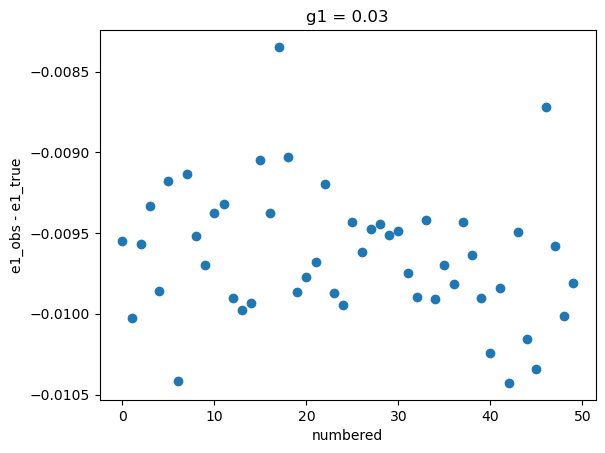

In [21]:
plt.scatter(np.arange(times),diff1)
plt.title('g1 = 0.03')
plt.xlabel('numbered')
plt.ylabel('e1_obs - e1_true')
plt.savefig('plot/g1=0,03')

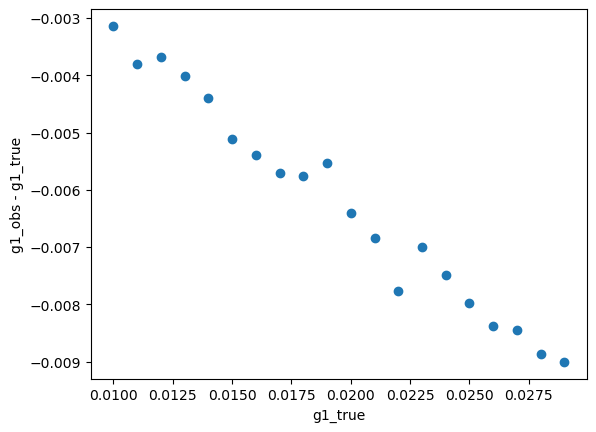

In [26]:
plt.scatter(shear,diff1)
plt.xlabel('g1_true')
plt.ylabel('g1_obs - g1_true')
plt.savefig('plot/diff')

## Test measurement on individual galaxy

In [ ]:
nobj=10

ini_e1=[]
fin_e1=[]
ini_e2=[]
fin_e2=[]
ini_size=[]
fin_size=[]
e1=[]
e2=[]
index=[]

samples = []

psf_sed = galsim.SED('1', wave_type='Angstrom', flux_type='flambda')
psf_star = galsim.DeltaFunction()
pixel_scale = roman.pixel_scale
wcs = galsim.PixelScale(pixel_scale) 
for i in range(nobj):
    a = random.randint(0, cat.nobjects-1)
    angle = random.random()*2*np.pi*galsim.radians
    # print(a)
    obj = cat.makeGalaxy(chromatic=True, gal_type='parametric', index=a)
    obj = obj.rotate(angle)
    try:
        im_obj = obj.drawImage(bandpass,nx=64,ny=64,wcs=wcs)
        final = galsim.Convolve(obj, psf)
        stamp = final.drawImage(bandpass, nx=64,ny=64, wcs = wcs)
        psf_img = galsim.Convolve([psf_star, psf]) * psf_sed.withFlux(1, bandpass)
        im_psf = psf_img.drawImage(bandpass,nx=32,ny=32,wcs=wcs)
        s = galsim.hsm.EstimateShear(stamp, im_psf)
        o = galsim.hsm.FindAdaptiveMom(im_obj, round_moments = False )
        # e1.append(100*abs(s.corrected_e1-o.observed_shape.e1)/abs(o.observed_shape.e1))
        # ini_e1.append(o.observed_shape.e1)
        # fin_e1.append(s.corrected_e1)
        # ini_e2.append(o.observed_shape.e2)
        # fin_e2.append(s.corrected_e2)
        # ini_size.append(o.moments_sigma)
        # fin_size.append(s.moments_sigma)
        # e2.append(100*abs(s.corrected_e2-o.observed_shape.e2)/abs(o.observed_shape.e2))
        # index.append(a)
    except galsim.GalSimFFTSizeError:
        pass
    except galsim.GalSimHSMError:
        pass

    # print(obj.index,s.corrected_e1,o.observed_shape.e1)
e1 = np.asarray(e1)
e2 = np.asarray(e2)
ini_e1 = np.asarray(ini_e1)
fin_e1 = np.asarray(fin_e1)
ini_e2 = np.asarray(ini_e2)
fin_e2 = np.asarray(fin_e2)
ini_size = np.asarray(ini_size)
fin_size = np.asarray(fin_size)
index = np.asarray(index)

In [ ]:
fin_e1.size, index.size

In [ ]:
np.where(e1 > 10), np.where(e2 > 10)

In [ ]:
index[4], e1[4], ini_size[7], ini_e2[7]

In [ ]:
e2[8]

In [ ]:
def remove_outliers(data_list, threshold=3):
    """
    Remove outliers from a list of numbers using z-scores with NumPy.

    Parameters:
        data_list (list): List of numbers.
        threshold (float): Z-score threshold for identifying outliers (default: 3).

    Returns:
        list: List with outliers removed.
    """
    data_array = np.array(data_list)
    z_scores = np.abs((data_array - np.mean(data_array)) / np.std(data_array))
    filtered_data = data_array[z_scores <= threshold]
    return np.asarray(filtered_data)

def trend_outliers(array1, array2, threshold=3):
    a = np.where(array1 > 1)
    for i in a:
        new_a1 = np.delete(array1,a)
        new_a2 = np.delete(array2,a)
        
    return new_a1, new_a2

In [ ]:
# e1 = remove_outliers(e1,threshold=1)

In [ ]:
# new_a1, new_a2 = trend_outliers(fin_e1,ini_e1)

In [ ]:
from scipy.stats import linregress

result = linregress(ini_e1, fin_e1 )

x = np.arange(-1,1.1,0.1)
y = x*result.slope + result.intercept

In [ ]:
result.slope, result.intercept

In [ ]:
plt.scatter(ini_e1,fin_e1)
plt.plot(x,y)
plt.xlabel('initial')
plt.ylabel('observe')
plt.title('e1')
plt.text(-1,1,f'slope: {result.slope}')
plt.text(-1,0.9,f'intercept: {result.intercept}')
plt.savefig('image/e1.png')

In [ ]:
result = linregress(ini_e2, fin_e2 )

x = np.arange(-1,1.1,0.1)
y = x*result.slope + result.intercept

plt.scatter(ini_e2,fin_e2)
plt.plot(x,y)
plt.xlabel('initial')
plt.ylabel('observe')
plt.title('e2')
plt.text(-1,1,f'slope: {result.slope}')
plt.text(-1,0.9,f'intercept: {result.intercept}')
plt.savefig('image/e2.png')

In [ ]:
result = linregress(ini_size, fin_size)
print(result.slope, result.intercept)
x = np.arange(0,12.1,0.1)
y = x*result.slope + result.intercept
plt.scatter(ini_size,fin_size)
plt.plot(x,y)
plt.xlabel('initial')
plt.ylabel('observe')
plt.text(0,11,f'slope: {result.slope}')
plt.text(0,10.5,f'intercept: {result.intercept}')
plt.title('Size')
plt.savefig('image/size.png')

In [ ]:
result.intercept/(1-result.slope)

In [ ]:
# x = np.arange(e1.shape[0])
# plt.scatter(x,e1)
plt.hist(e1, range=(0,300), bins = 30)
# plt.xticks([0,5,10,15,20,40,45,50,55,60,70,75])
plt.xlabel('difference (%)')
plt.ylabel('counts')
plt.title('e1')
plt.savefig('image/histo_e1.png')

In [ ]:
plt.hist(e2, range=(0,300), bins = 30)
# plt.xticks([0,5,10,15,20,40,45,50,55,60,70,75])
plt.xlabel('difference (%)')
plt.ylabel('counts')
plt.title('e2')
plt.savefig('image/histo_e2.png')

In [ ]:
plt.hist2d(e1,e2,range=((0,100),(0,100)),bins=10)
plt.colorbar()

# Multiple objects

In [ ]:
nobj = 100

bandpass = roman_filters['Y106']

psf = roman.getPSF(use_SCA, 'Y106', n_waves=10, wcs=wcs, pupil_bin=8)

# Set up the full image for the galaxies
full_image = galsim.ImageF(roman.n_pix, roman.n_pix, wcs=wcs)

# image_rng = galsim.UniformDeviate(seed1 + nobj)

for i_obj in range(nobj):
    
    obj_rng = galsim.UniformDeviate(seed + 1 + 10**6 + i_obj)

    p = obj_rng()

    x = obj_rng() * roman.n_pix
    y = obj_rng() * roman.n_pix
    image_pos = galsim.PositionD(x,y)
    logger.debug('Position = %s',image_pos)

    # Now decide which of our three kinds of objects we want to draw:
    # 80% faint galaxy
    # 10% star
    # 10% bright galaxy
    if p < 0.9:
        # Faint galaxy
        logger.debug('Faint galaxy')

        # Select a random galaxy from the catalog.
        obj = cat1.makeGalaxy(chromatic=True, gal_type='parametric', rng=obj_rng)
        print(obj.index)
        # # Rotate the galaxy randomly
        # theta = obj_rng() * 2 * np.pi * galsim.radians
        # logger.debug('theta = %s',theta)
        # obj = obj.rotate(theta)

    else:
        # Bright galaxy
        logger.debug('Bright galaxy')

        obj = cat2.makeGalaxy(chromatic=True, gal_type='parametric', rng=obj_rng)
        print(obj.index)
        # Scale up the area by a factor of 2, and the flux by a factor of 4.
        # This is not necessarily physical, but it is intended to add some more big,
        # bright galaxies to the scene to make the final image a bit more interesting.
#         obj = obj.dilate(2) * 4

#         # Rotate the galaxy randomly
#         theta = obj_rng() * 2 * np.pi * galsim.radians
#         logger.debug('theta = %s',theta)
#         obj = obj.rotate(theta)

    # Convolve the (chromatic) object with the (chromatic) PSF.
    final = galsim.Convolve(obj, psf)
    stamp = final.drawImage(bandpass, center=image_pos, wcs=wcs.local(image_pos))

    # Find the overlapping bounds between the large image and the individual stamp.
    bounds = stamp.bounds & full_image.bounds

    # Add this to the corresponding location in the large image.
    full_image[bounds] += stamp[bounds]

In [ ]:
full_image

In [ ]:
data=fits.open("output/demo13_Z087.fits")
data=data[0].data

m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

In [ ]:
import sep

data = data.byteswap(inplace=True).newbyteorder()
bkg = sep.Background(data)
bkg_image = bkg.back()
bkg_rms = bkg.rms()
data_sub = data - bkg
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)
len(objects)

In [ ]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)